# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.optimize import Bounds

In [3]:
plt.rcParams.update({
    "text.usetex": True
})

In [4]:
import dirichlet_regression

In [5]:
from scipy.optimize import fmin, newton, minimize

# Generating synthetic data, with an intercept

In [6]:
n_features = 1
n_classes = 3
n_samples = 100

In [356]:
np.random.seed(1)

beta = np.zeros((n_features+1,n_classes))
beta[:,1:] = 2*np.round(np.random.uniform(size=(n_features+1,n_classes-1)),2)

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x)) for x in X])
#Z = np.random.uniform(size=(n_samples,n_features))
Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [357]:
neighbors = NearestNeighbors(n_neighbors=50).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

In [358]:
mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))

In [359]:
alpha = mu*phi[:,None]

In [360]:
np.random.seed(1)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [361]:
X_for_plot = np.ones((100,n_features+1))
X_for_plot[:,1] = np.arange(0,1,0.01)
neighbors_for_plot = NearestNeighbors(n_neighbors=50).fit(X_for_plot[:,1:])
W_for_plot = neighbors_for_plot.kneighbors_graph(X_for_plot[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)
mu_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta, rho, W_for_plot)

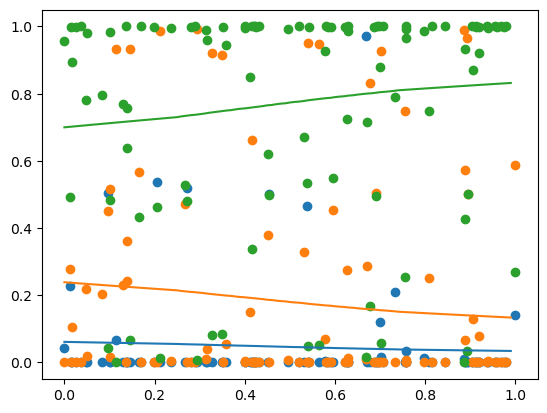

In [81]:
plt.scatter(X[:,1],Y[:,0])
plt.scatter(X[:,1],Y[:,1])
plt.scatter(X[:,1],Y[:,2])
plt.plot(X_for_plot[:,1], mu_for_plot)
plt.show()

## Finding the solution

In [7]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [8]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,[rho_derivative]]))

In [72]:
#beta0 = np.array([[0., 0.05, 0.06]])
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [16]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [89]:
%%time
solution_1 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)

Wall time: 751 ms


In [18]:
solution_1.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [90]:
beta_sol_1 = solution_1.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_sol_1 = solution_1.x[-1]

In [91]:
mu_sol_1 = dirichlet_regression.compute_mu_spatial(X, beta_sol_1, rho_sol_1, W)
gamma_var_sol_1 = solution_1.x[(n_features+1)*n_classes:-1]
phi_sol_1 = np.exp(np.matmul(Z,gamma_var_sol_1))

In [21]:
print('PREDICTED')
print('beta',beta_sol_1)
print('gamma',gamma_var_sol_1)
print('rho',rho_sol_1)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)
print('rho',rho)

PREDICTED
beta [[0.         1.34482344 2.95126008]
 [0.         0.57314239 1.10850911]]
gamma [-0.68937509]
rho -0.26593819678432706
----- 
REAL
beta [[0.   0.84 1.44]
 [0.   0.   0.6 ]]
gamma [-0.53]
rho 0.382


In [22]:
mu_sol_1_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_1, rho_sol_1, W_for_plot)

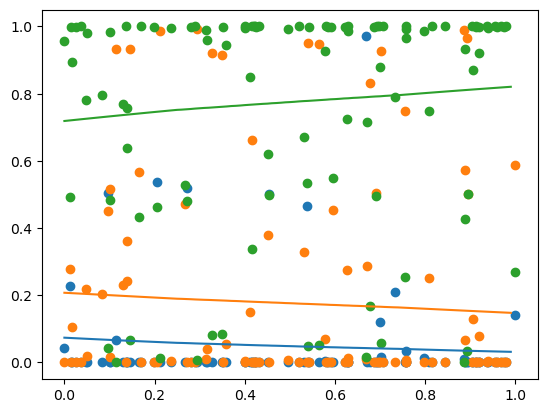

In [23]:
plt.scatter(X[:,1],Y[:,0])
plt.scatter(X[:,1],Y[:,1])
plt.scatter(X[:,1],Y[:,2])
#plt.plot(X_for_plot[:,1], mu_for_plot)
plt.plot(X_for_plot[:,1], mu_sol_1_for_plot)
plt.show()

In [24]:
r2_score(mu,mu_sol_1)

0.7747383004644094

# With X^2

In [25]:
np.random.seed(22)

beta = np.zeros((n_features+2,n_classes))
beta[:,1:] = 2*np.round(np.random.uniform(size=(n_features+2,n_classes-1)),2)

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x,x**2)) for x in X])
#Z = np.random.uniform(size=(n_samples,n_features))
Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [26]:
neighbors = NearestNeighbors(n_neighbors=50).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

In [27]:
mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))

In [28]:
alpha = mu*phi[:,None]

In [29]:
np.random.seed(22)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [30]:
X_for_plot = np.arange(0,1,0.01)
X_for_plot = np.array([[1,x,x**2] for x in X_for_plot])
neighbors_for_plot = NearestNeighbors(n_neighbors=50).fit(X_for_plot[:,1:])
W_for_plot = neighbors_for_plot.kneighbors_graph(X_for_plot[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)
mu_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta, rho, W_for_plot)

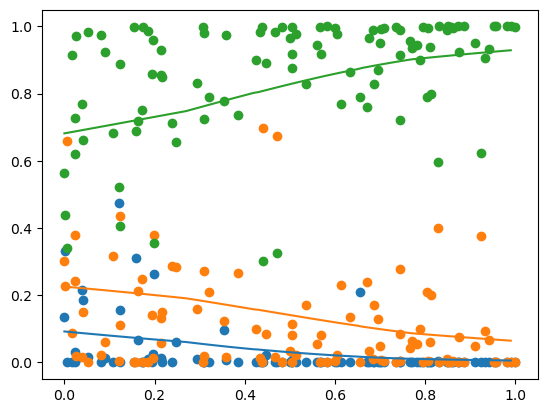

In [31]:
plt.scatter(X[:,1],Y[:,0])
plt.scatter(X[:,1],Y[:,1])
plt.scatter(X[:,1],Y[:,2])
plt.plot(X_for_plot[:,1], mu_for_plot)
plt.show()

## Finding the solution

In [32]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [33]:
min_bounds_2 = -np.inf*np.ones(len(params0)) 
max_bounds_2 = np.inf*np.ones(len(params0))
min_bounds_2[-1] = -1
max_bounds_2[-1] = 1
bounds_2 = Bounds(min_bounds_2, max_bounds_2)

In [34]:
%%time
solution_2 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_2)

Wall time: 5.83 s


In [35]:
solution_2.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [36]:
beta_sol_2 = solution_2.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_sol_2 = solution_2.x[-1]
mu_sol_2 = dirichlet_regression.compute_mu_spatial(X, beta_sol_2, rho_sol_2, W)
gamma_var_sol_2 = solution_2.x[(n_features+2)*n_classes:-1]
phi_sol_2 = np.exp(np.matmul(Z,gamma_var_sol_2))

In [37]:
print('PREDICTED')
print('beta',beta_sol_2)
print('gamma',gamma_var_sol_2)
print('rho',rho_sol_2)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)
print('rho',rho)

PREDICTED
beta [[ 0.          1.46795252  4.11170657]
 [ 0.          2.85252883  3.2471217 ]
 [ 0.         -0.57739661  1.70659021]]
gamma [1.16066142]
rho -0.6827581088054767
----- 
REAL
beta [[0.   0.42 0.96]
 [0.   0.84 1.72]
 [0.   0.34 0.68]]
gamma [0.92]
rho 0.409


In [38]:
mu_sol_2_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_2, rho_sol_2, W_for_plot)

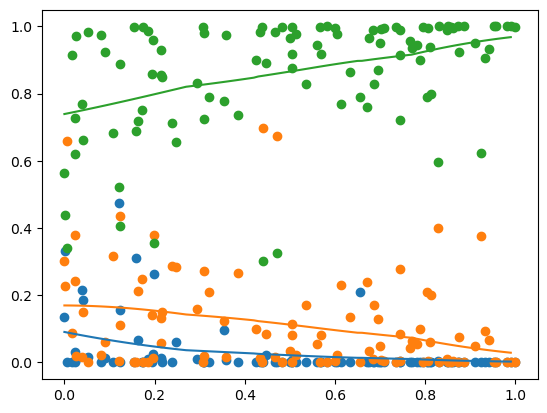

In [39]:
plt.scatter(X[:,1],Y[:,0])
plt.scatter(X[:,1],Y[:,1])
plt.scatter(X[:,1],Y[:,2])
#plt.plot(X_for_plot[:,1], mu_for_plot)
plt.plot(X_for_plot[:,1], mu_sol_2_for_plot)
plt.show()

In [40]:
r2_score(mu,mu_sol_2)

0.7270746105925424

# With a hand-made shape

In [8]:
n_features = 1
n_classes = 3
n_samples = 100

np.random.seed(3)

beta = np.array([[0., -1., 1.],
                 [0., 2.,  -2.],
                 [0., 0.6, -0.6 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x,x**2)) for x in X])
Z = np.random.uniform(size=(n_samples,n_features))
#Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [9]:
neighbors = NearestNeighbors(n_neighbors=50).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

In [94]:
# OTHER WAY OF CREATING W 

neighbors = NearestNeighbors(n_neighbors=10).fit(np.arange(n_samples).reshape(-1,1))
W = neighbors.kneighbors_graph(np.arange(n_samples).reshape(-1,1)).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

In [95]:
mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))

In [96]:
alpha = mu*phi[:,None]

In [97]:
np.random.seed(3)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [111]:
X_for_plot = np.arange(0,1,0.01)
X_for_plot = np.array([[1,x,x**2] for x in X_for_plot])
neighbors_for_plot = NearestNeighbors(n_neighbors=10).fit(np.arange(len(X_for_plot)).reshape(-1,1))
W_for_plot = neighbors_for_plot.kneighbors_graph(np.arange(len(X_for_plot)).reshape(-1,1)).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)
mu_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta, rho, W_for_plot)

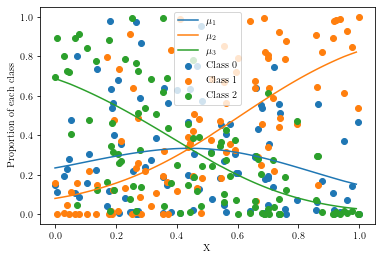

In [112]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
plt.plot(X_for_plot[:,1], mu_for_plot[:,0], label='$\mu_1$')
plt.plot(X_for_plot[:,1], mu_for_plot[:,1], label='$\mu_2$')
plt.plot(X_for_plot[:,1], mu_for_plot[:,2], label='$\mu_3$')
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

## Finding the solution

In [113]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [114]:
min_bounds_3 = -np.inf*np.ones(len(params0)) 
max_bounds_3 = np.inf*np.ones(len(params0))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [115]:
%%time
solution_3 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_3, jac=fprime_spatial)

Wall time: 1.84 s


In [116]:
solution_3.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [117]:
beta_sol_3 = solution_3.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_sol_3 = solution_3.x[-1]
mu_sol_3 = dirichlet_regression.compute_mu_spatial(X, beta_sol_3, rho_sol_3, W)
gamma_var_sol_3 = solution_3.x[(n_features+2)*n_classes:-1]
phi_sol_3 = np.exp(np.matmul(Z,gamma_var_sol_3))

In [118]:
print('PREDICTED')
print('beta',beta_sol_3)
print('gamma',gamma_var_sol_3)
print('rho',rho_sol_3)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)
print('rho',rho)

PREDICTED
beta [[ 0.         -1.47568772  0.54449826]
 [ 0.          3.45761334 -1.56385229]
 [ 0.         -0.28261656 -0.37262825]]
gamma [1.63285181]
rho -0.27902849119803763
----- 
REAL
beta [[ 0.  -1.   1. ]
 [ 0.   2.  -2. ]
 [ 0.   0.6 -0.6]]
gamma [1.79]
rho 0.078


In [119]:
mu_sol_3_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_3, rho_sol_3, W_for_plot)

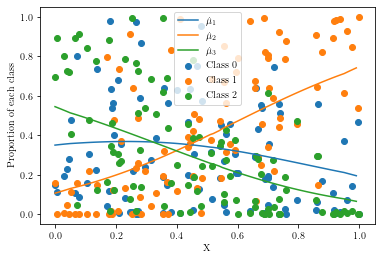

In [120]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
#plt.plot(X_for_plot[:,1], mu_for_plot)
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], label='$\hat\mu_1$')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], label='$\hat\mu_2$')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], label='$\hat\mu_3$')
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [121]:
print('R2 score mu :',r2_score(mu,mu_sol_3))
print('RMSE mu :',mean_squared_error(mu,mu_sol_3,squared=False))

R2 score mu : 0.695758728413114
RMSE mu : 0.03773129464478742


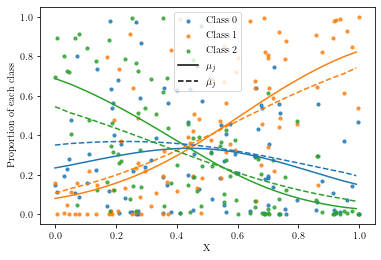

In [122]:
class0=plt.scatter(X[:,1],Y[:,0], alpha=.8, s=10)
class1=plt.scatter(X[:,1],Y[:,1], alpha=.8, s=10)
class2=plt.scatter(X[:,1],Y[:,2],alpha=.8, s=10)
plt.plot(X_for_plot[:,1], mu_for_plot[:,0])
plt.plot(X_for_plot[:,1], mu_for_plot[:,1])
plt.plot(X_for_plot[:,1], mu_for_plot[:,2])
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], '--', color='tab:blue')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], '--', color='tab:orange')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], '--', color='tab:green')

line = plt.Line2D([],[],linestyle='-', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
plt.legend([class0,class1,class2,line,dashed_line],['Class 0','Class 1','Class 2','$\mu_j$','$\hat\mu_j$'])
plt.legend
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [123]:
print('R2 score between Y and mu :',r2_score(Y,mu_sol_3))
print('RMSE between Y and mu :',mean_squared_error(Y,mu_sol_3,squared=False))

R2 score between Y and mu : 0.29243042762041477
RMSE between Y and mu : 0.2421917230587627


## Solution without spatial

In [9]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [124]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
params0_no_spatial = np.concatenate([beta0.flatten(),gamma0])

In [125]:
min_bounds_3 = -np.inf*np.ones(len(params0_no_spatial)) 
max_bounds_3 = np.inf*np.ones(len(params0_no_spatial))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [126]:
%%time
solution_3 = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), bounds=bounds_3)

Wall time: 1.49 s


In [127]:
solution_3.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [128]:
beta_sol_3 = solution_3.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
mu_sol_3 = dirichlet_regression.compute_mu_3(X, beta_sol_3)
gamma_var_sol_3 = solution_3.x[(n_features+2)*n_classes:]
phi_sol_3 = np.exp(np.matmul(Z,gamma_var_sol_3))

In [129]:
print('PREDICTED')
print('beta',beta_sol_3)
print('gamma',gamma_var_sol_3)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)

PREDICTED
beta [[ 0.         -1.24727421  0.4627453 ]
 [ 0.          2.85636302 -0.74652819]
 [ 0.         -0.07285465 -0.93402188]]
gamma [1.]
----- 
REAL
beta [[ 0.  -1.   1. ]
 [ 0.   2.  -2. ]
 [ 0.   0.6 -0.6]]
gamma [1.79]


In [130]:
mu_sol_3_for_plot = dirichlet_regression.compute_mu_3(X_for_plot, beta_sol_3)

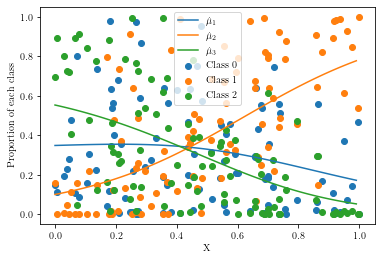

In [131]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], label='$\hat\mu_1$')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], label='$\hat\mu_2$')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], label='$\hat\mu_3$')
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [132]:
print('R2 score mu :',r2_score(mu,mu_sol_3))
print('RMSE mu :',mean_squared_error(mu,mu_sol_3,squared=False))

R2 score mu : 0.7278832426085052
RMSE mu : 0.033678335817847106


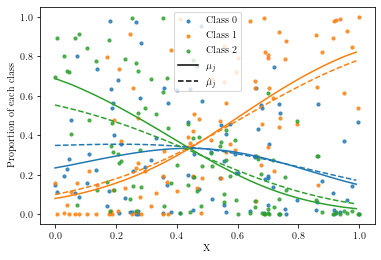

In [133]:
class0=plt.scatter(X[:,1],Y[:,0], alpha=.8, s=10)
class1=plt.scatter(X[:,1],Y[:,1], alpha=.8, s=10)
class2=plt.scatter(X[:,1],Y[:,2],alpha=.8, s=10)
plt.plot(X_for_plot[:,1], mu_for_plot[:,0])
plt.plot(X_for_plot[:,1], mu_for_plot[:,1])
plt.plot(X_for_plot[:,1], mu_for_plot[:,2])
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], '--', color='tab:blue')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], '--', color='tab:orange')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], '--', color='tab:green')

line = plt.Line2D([],[],linestyle='-', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
plt.legend([class0,class1,class2,line,dashed_line],['Class 0','Class 1','Class 2','$\mu_j$','$\hat\mu_j$'])
plt.legend
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [134]:
print('R2 score between Y and mu :',r2_score(Y,mu_sol_3))
print('RMSE between Y and mu :',mean_squared_error(Y,mu_sol_3,squared=False))

R2 score between Y and mu : 0.282807959595434
RMSE between Y and mu : 0.2441363365309359


# Value of $\rho$ depending on the number of points

In [818]:
np.random.seed(3)

beta = np.array([[0., -1., 1.],
                 [0., 2.,  -2.],
                 [0., 0.6, -0.6 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

rho = np.round(np.random.uniform(-1,1),3)

In [819]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

min_bounds_3 = -np.inf*np.ones(len(params0)) 
max_bounds_3 = np.inf*np.ones(len(params0))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [820]:
list_nb_points = [50, 100, 200, 500, 1000]

In [823]:
np.random.seed(3)
list_rhos = []
for nb_points in list_nb_points:
    X = np.random.uniform(size=(nb_points,n_features))
    X = (X-X.min())/(X.max()-X.min())
    X = np.array([np.concatenate(([1],x,x**2)) for x in X])
    Z = np.ones((nb_points,n_features))
    neighbors = NearestNeighbors(n_neighbors=20).fit(X[:,1:])
    W = neighbors.kneighbors_graph(X[:,1:]).toarray()
    # replace the 1 on the diagonal by 0
    np.fill_diagonal(W,0)
    # scaling the matrix, so that the sum of each row is 1
    W = W/W.sum(axis=1)[:,None]
    mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = mu*phi[:,None]
    Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
    
    solution_3 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_3)
    list_rhos.append(solution_3.x[-1])

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [825]:
print('Real rho :', rho)
list_rhos

Real rho : -0.418


[-0.5460865417080072, -1.0, 0.45068660874102445, 0.5582945102432799, -1.0]

# Generating several points with same X

In [94]:
np.random.seed(3)

beta = np.array([[0., -1., 1.],
                 [0., 2.,  -2.],
                 [0., 0.6, -0.6 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

rho = np.round(np.random.uniform(-1,1),3)

X = np.random.uniform(size=(100,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x,x**2)) for x in X])

beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

min_bounds_3 = -np.inf*np.ones(len(params0)) 
max_bounds_3 = np.inf*np.ones(len(params0))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [95]:
X = np.repeat(X,10,axis=0)

In [96]:
Z = np.ones((1000,n_features))
neighbors = NearestNeighbors(n_neighbors=30).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]
mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [97]:
%%time
solution_3 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_3, jac=fprime_spatial)

Wall time: 19.9 s


In [98]:
beta_sol_3 = solution_3.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_sol_3 = solution_3.x[-1]
mu_sol_3 = dirichlet_regression.compute_mu_spatial(X, beta_sol_3, rho_sol_3, W)
gamma_var_sol_3 = solution_3.x[(n_features+2)*n_classes:-1]
phi_sol_3 = np.exp(np.matmul(Z,gamma_var_sol_3))

In [99]:
r2_score(mu,mu_sol_3)

0.9525677191001645

In [100]:
X_for_plot = np.arange(0,1,0.01)
X_for_plot = np.array([[1,x,x**2] for x in X_for_plot])
neighbors_for_plot = NearestNeighbors(n_neighbors=50).fit(X_for_plot[:,1:])
W_for_plot = neighbors_for_plot.kneighbors_graph(X_for_plot[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)
mu_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta, rho, W_for_plot)
mu_sol_3_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_3, rho_sol_3, W_for_plot)

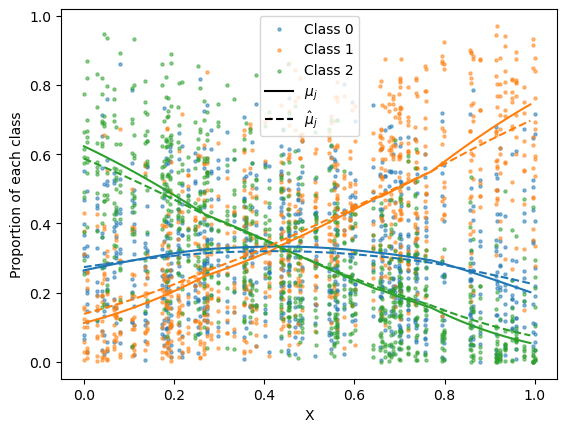

In [101]:
class0=plt.scatter(X[:,1],Y[:,0], alpha=.5, s=5)
class1=plt.scatter(X[:,1],Y[:,1], alpha=.5, s=5)
class2=plt.scatter(X[:,1],Y[:,2],alpha=.5, s=5)
plt.plot(X_for_plot[:,1], mu_for_plot[:,0])
plt.plot(X_for_plot[:,1], mu_for_plot[:,1])
plt.plot(X_for_plot[:,1], mu_for_plot[:,2])
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], '--', color='tab:blue')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], '--', color='tab:orange')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], '--', color='tab:green')

line = plt.Line2D([],[],linestyle='-', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
plt.legend([class0,class1,class2,line,dashed_line],['Class 0','Class 1','Class 2','$\mu_j$','$\hat\mu_j$'])
plt.legend
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [67]:
solution_3.x

array([ 0.        , -0.72227458,  0.82407068,  0.        ,  1.79138106,
       -1.58498469,  0.        ,  0.18797431, -0.44786151,  1.77058116,
       -0.18313445])

In [68]:
beta

array([[ 0. , -1. ,  1. ],
       [ 0. ,  2. , -2. ],
       [ 0. ,  0.6, -0.6]])

In [69]:
rho

-0.418

# With two features

In [326]:
n_features = 2
n_classes = 3
n_samples = 100

In [327]:
beta

array([[0.  , 0.16, 1.56, 0.88, 1.44, 1.96, 1.08, 1.  , 0.14, 0.54],
       [0.  , 1.  , 1.36, 1.6 , 0.76, 0.14, 0.58, 1.82, 0.42, 0.9 ],
       [0.  , 1.86, 0.04, 1.2 , 1.9 , 0.46, 1.1 , 1.82, 0.26, 1.04],
       [0.  , 1.5 , 1.34, 0.94, 0.4 , 0.98, 0.74, 0.96, 0.74, 1.68],
       [0.  , 1.54, 0.62, 1.14, 0.56, 0.9 , 0.7 , 1.32, 0.74, 0.92],
       [0.  , 1.44, 0.82, 1.82, 0.36, 1.48, 0.84, 0.86, 1.26, 1.04],
       [0.  , 0.82, 0.  , 0.18, 1.42, 1.04, 1.4 , 1.92, 1.36, 0.1 ],
       [0.  , 0.62, 1.18, 0.48, 1.92, 1.9 , 1.7 , 0.94, 1.68, 0.26],
       [0.  , 0.62, 0.92, 1.48, 0.98, 0.28, 0.68, 0.64, 0.6 , 0.34],
       [0.  , 0.82, 0.9 , 1.54, 1.6 , 1.04, 0.92, 1.56, 1.78, 1.34],
       [0.  , 1.6 , 1.88, 0.08, 1.76, 0.56, 0.96, 1.6 , 1.44, 0.3 ],
       [0.  , 1.32, 0.14, 0.72, 1.62, 0.86, 1.2 , 1.46, 1.64, 1.52],
       [0.  , 0.02, 0.84, 0.92, 0.12, 1.08, 1.22, 1.66, 1.88, 0.26],
       [0.  , 0.46, 1.32, 0.26, 0.44, 1.14, 0.34, 1.56, 1.72, 0.06],
       [0.  , 1.06, 1.6 , 1.96, 0.

In [328]:
np.random.seed(21)

#beta = np.zeros((n_features+1,n_classes))
#beta[:,1:] = 2*np.round(np.random.uniform(size=(n_features+1,n_classes-1)),2)
beta = np.array([[0.  , -1.2 , 1.1],
                 [0.  , 1.9, -1.8],
                 [0.  , 1.5, -1.2 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x)) for x in X])
#Z = np.random.uniform(size=(n_samples,n_features))
Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [329]:
neighbors = NearestNeighbors(n_neighbors=40).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

In [330]:
np.random.seed(21)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [331]:
X_for_plot_1,X_for_plot_2 = np.meshgrid(np.arange(0,1,0.05),np.arange(0,1,0.05))
X_for_plot = np.ones((400,n_features+1))
X_for_plot[:,1],X_for_plot[:,2] = X_for_plot_1.flatten(),X_for_plot_2.flatten()

neighbors_for_plot = NearestNeighbors(n_neighbors=40).fit(X_for_plot[:,1:])
W_for_plot = neighbors_for_plot.kneighbors_graph(X_for_plot[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)
mu_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta, rho, W_for_plot)

<IPython.core.display.Javascript object>


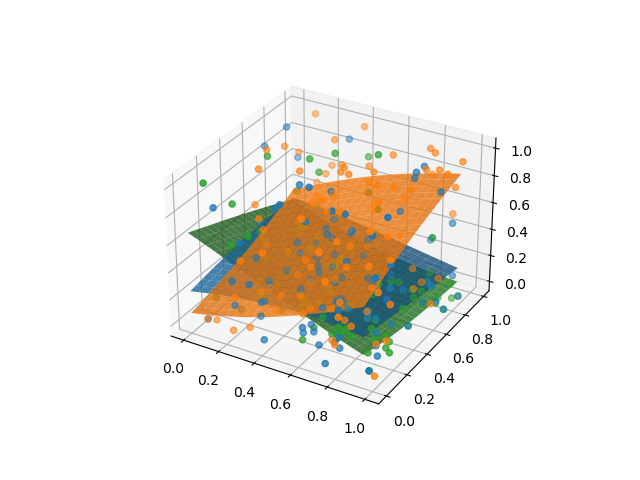

In [332]:
%matplotlib notebook
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X[:,1],X[:,2],Y[:,0])
ax.scatter(X[:,1],X[:,2],Y[:,1])
ax.scatter(X[:,1],X[:,2],Y[:,2])

ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,0].reshape(X_for_plot_1.shape), alpha=.8)
ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,1].reshape(X_for_plot_1.shape), alpha=.8)
ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,2].reshape(X_for_plot_1.shape), alpha=.8)
plt.show()

## Finding the solution

In [334]:
#beta0 = np.array([[0., 0.05, 0.06]])
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = [0.,0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [335]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [336]:
%%time
solution_1 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_1, jac=fprime_spatial)

Wall time: 786 ms


In [337]:
solution_1.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [338]:
beta_sol_1 = solution_1.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_sol_1 = solution_1.x[-1]

In [339]:
mu_sol_1 = dirichlet_regression.compute_mu_spatial(X, beta_sol_1, rho_sol_1, W)
gamma_var_sol_1 = solution_1.x[(n_features+1)*n_classes:-1]
phi_sol_1 = np.exp(np.matmul(Z,gamma_var_sol_1))

In [340]:
print('PREDICTED')
print('beta',beta_sol_1)
print('gamma',gamma_var_sol_1)
print('rho',rho_sol_1)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)
print('rho',rho)

PREDICTED
beta [[ 0.         -0.40522369  1.23735033]
 [ 0.          0.90277248 -1.54997605]
 [ 0.          0.71933718 -1.19024534]]
gamma [-0.05493105 -0.05493105]
rho 0.36370383543987495
----- 
REAL
beta [[ 0.  -1.2  1.1]
 [ 0.   1.9 -1.8]
 [ 0.   1.5 -1.2]]
gamma [-0.05 -0.11]
rho -0.135


In [341]:
mu_sol_1_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_1, rho_sol_1, W_for_plot)

<IPython.core.display.Javascript object>


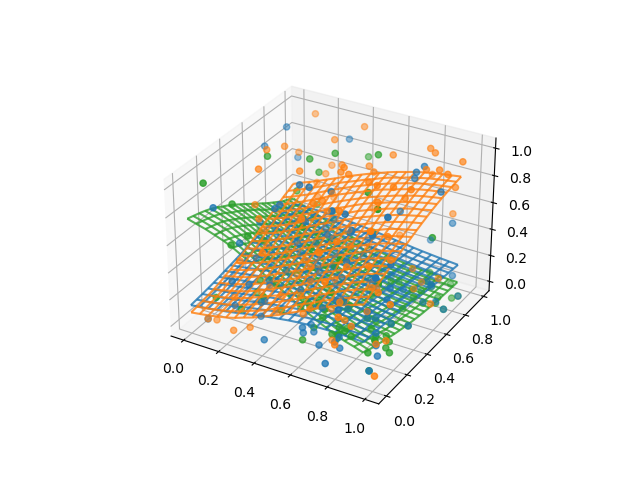

In [342]:
%matplotlib notebook
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X[:,1],X[:,2],Y[:,0])
ax.scatter(X[:,1],X[:,2],Y[:,1])
ax.scatter(X[:,1],X[:,2],Y[:,2])

ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,0].reshape(X_for_plot_1.shape), alpha=.8, color='tab:blue')
ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,1].reshape(X_for_plot_1.shape), alpha=.8, color='tab:orange')
ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,2].reshape(X_for_plot_1.shape), alpha=.8, color='tab:green')
plt.show()

In [343]:
r2_score(mu,mu_sol_1)

0.7634022574753366

In [344]:
print('RMSE on mu:',mean_squared_error(mu, mu_sol_1, squared=False))

RMSE on mu: 0.03136838597443665


In [346]:
print('RMSE on beta:',mean_squared_error(beta, beta_sol_1, squared=False))

RMSE on beta: 0.3426794272043343


In [345]:
print('RMSE on gamma:',mean_squared_error(gamma_var, gamma_var_sol_1, squared=False))

RMSE on gamma: 0.03909542548250748


<IPython.core.display.Javascript object>


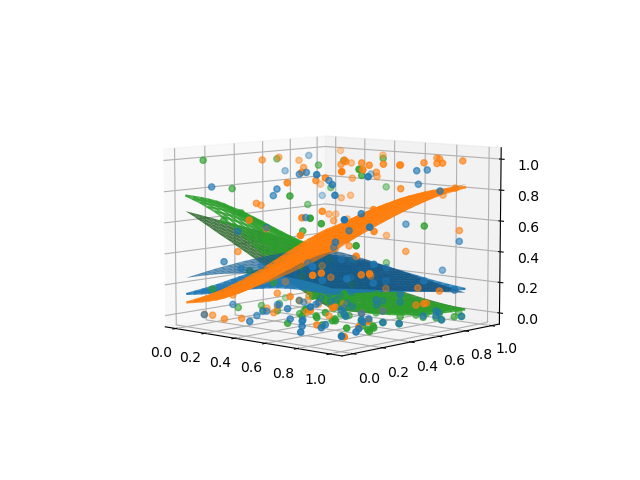

In [280]:
%matplotlib notebook
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X[:,1],X[:,2],Y[:,0])
ax.scatter(X[:,1],X[:,2],Y[:,1])
ax.scatter(X[:,1],X[:,2],Y[:,2])

ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,0].reshape(X_for_plot_1.shape), alpha=.8)
ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,1].reshape(X_for_plot_1.shape), alpha=.8)
ax.plot_surface(X_for_plot_1, X_for_plot_2,mu_for_plot[:,2].reshape(X_for_plot_1.shape), alpha=.8)

ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,0].reshape(X_for_plot_1.shape), alpha=.8, color='tab:blue')
ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,1].reshape(X_for_plot_1.shape), alpha=.8, color='tab:orange')
ax.plot_wireframe(X_for_plot_1, X_for_plot_2,mu_sol_1_for_plot[:,2].reshape(X_for_plot_1.shape), alpha=.8, color='tab:green')
plt.show()

# Test with higher dimension

In [282]:
n_features = 16
n_classes = 10
n_samples = 1000

In [299]:
np.random.seed(7)

beta = np.zeros((n_features+1,n_classes))
beta[:,1:] = 2*np.round(np.random.uniform(size=(n_features+1,n_classes-1)),2)

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x)) for x in X])
#Z = np.random.uniform(size=(n_samples,n_features))
Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [300]:
neighbors = NearestNeighbors(n_neighbors=50).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

In [301]:
np.random.seed(7)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [310]:
Y_star = (Y*(n_samples-1)+1/n_classes)/n_samples

## Finding the solution

In [313]:
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = np.zeros(n_features)
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [314]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [315]:
%%time
solution_1 = minimize(f_spatial, params0, args=(X, Y_star, Z, W), bounds=bounds_1, jac=fprime_spatial)

Wall time: 2min 34s


In [316]:
solution_1.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [317]:
beta_sol_1 = solution_1.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_sol_1 = solution_1.x[-1]

In [318]:
mu_sol_1 = dirichlet_regression.compute_mu_spatial(X, beta_sol_1, rho_sol_1, W)
gamma_var_sol_1 = solution_1.x[(n_features+1)*n_classes:-1]
phi_sol_1 = np.exp(np.matmul(Z,gamma_var_sol_1))

In [324]:
print('RMSE on beta:',mean_squared_error(beta, beta_sol_1, squared=False))

RMSE om beta: 0.9505560085685246


In [ ]:
print('RMSE on gamma:',mean_squared_error(gamma_var, gamma_var_sol_1, squared=False))

In [320]:
r2_score(mu,mu_sol_1)

-444.89078752130865

In [325]:
print('RMSE on mu:',mean_squared_error(mu, mu_sol_1, squared=False))

RMSE on mu: 0.030167728410605422


# Large classes dimension (microbiome)

In [408]:
n_features = 20
n_classes = 100
n_samples = 100

In [409]:
np.random.seed(777)

beta = np.zeros((n_features+1,n_classes))
beta[:,1:] = 2*np.round(np.random.uniform(size=(n_features+1,n_classes-1)),2)

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x)) for x in X])
#Z = np.random.uniform(size=(n_samples,n_features))
Z = np.ones((n_samples,n_features))

rho = np.round(np.random.uniform(-1,1),3)

In [410]:
neighbors = NearestNeighbors(n_neighbors=50).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

mu = dirichlet_regression.compute_mu_spatial(X, beta, rho, W)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = mu*phi[:,None]

In [411]:
np.random.seed(777)
Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])
Y_star = (Y*(n_samples-1)+1/n_classes)/n_samples

## Finding the solution

In [412]:
beta0 = np.zeros((n_features+1,n_classes))
gamma0 = np.zeros(n_features)
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [413]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds_1 = Bounds(min_bounds_1, max_bounds_1)

In [414]:
%%time
solution_1 = minimize(f_spatial, params0, args=(X, Y_star, Z, W), bounds=bounds_1, jac=fprime_spatial)

Wall time: 12min 45s


In [415]:
solution_1.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [416]:
beta_sol_1 = solution_1.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_sol_1 = solution_1.x[-1]

In [417]:
mu_sol_1 = dirichlet_regression.compute_mu_spatial(X, beta_sol_1, rho_sol_1, W)
gamma_var_sol_1 = solution_1.x[(n_features+1)*n_classes:-1]
phi_sol_1 = np.exp(np.matmul(Z,gamma_var_sol_1))

In [418]:
print('RMSE on beta:',mean_squared_error(beta, beta_sol_1, squared=False))

RMSE on beta: 1.111845556701599


In [419]:
print('RMSE on gamma:',mean_squared_error(gamma_var, gamma_var_sol_1, squared=False))

RMSE on gamma: 0.8463227460729171


In [421]:
print('RMSE on mu:',mean_squared_error(mu, mu_sol_1, squared=False))

RMSE on mu: 0.0032103760945704414


# What if the generated data does not use spatial?

In [422]:
n_features = 1
n_classes = 3
n_samples = 100

np.random.seed(11)

beta = np.array([[0., -1., 1.],
                 [0., 2.,  -2.],
                 [0., 0.6, -0.6 ]])

gamma_var = np.round(np.random.normal(size=(n_features)),2)

X = np.random.uniform(size=(n_samples,n_features))
X = (X-X.min())/(X.max()-X.min())
X = np.array([np.concatenate(([1],x,x**2)) for x in X])
Z = np.ones((n_samples,n_features))

mu = dirichlet_regression.compute_mu_3(X, beta)
phi = np.exp(np.matmul(Z,gamma_var))

alpha = mu*phi[:,None]

Y = np.array([np.random.dirichlet(alpha_i) for alpha_i in alpha])

In [423]:
X_for_plot = np.arange(0,1,0.01)
X_for_plot = np.array([[1,x,x**2] for x in X_for_plot])

neighbors_for_plot = NearestNeighbors(n_neighbors=50).fit(X_for_plot[:,1:])
W_for_plot = neighbors_for_plot.kneighbors_graph(X_for_plot[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_for_plot,0)
# scaling the matrix, so that the sum of each row is 1
W_for_plot = W_for_plot/W_for_plot.sum(axis=1)

mu_for_plot = dirichlet_regression.compute_mu_3(X_for_plot, beta)

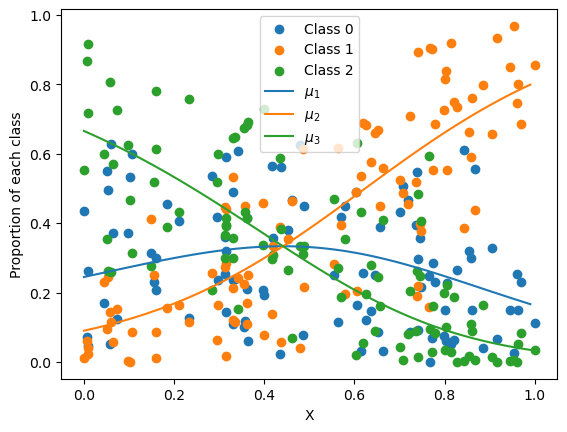

In [424]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
plt.plot(X_for_plot[:,1], mu_for_plot, label=['$\mu_1$','$\mu_2$','$\mu_3$'])
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

### Solution without spatial

In [425]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
params0_no_spatial = np.concatenate([beta0.flatten(),gamma0])

In [426]:
min_bounds_3 = -np.inf*np.ones(len(params0_no_spatial)) 
max_bounds_3 = np.inf*np.ones(len(params0_no_spatial))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [427]:
%%time
solution_3 = minimize(f_no_spatial, params0_no_spatial, args=(X, Y, Z), bounds=bounds_3)

Wall time: 671 ms


In [428]:
solution_3.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [429]:
beta_sol_3 = solution_3.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
mu_sol_3 = dirichlet_regression.compute_mu_3(X, beta_sol_3)
gamma_var_sol_3 = solution_3.x[(n_features+2)*n_classes:]
phi_sol_3 = np.exp(np.matmul(Z,gamma_var_sol_3))

In [430]:
print('PREDICTED')
print('beta',beta_sol_3)
print('gamma',gamma_var_sol_3)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)

PREDICTED
beta [[ 0.         -0.82770228  0.48823702]
 [ 0.          1.85809829 -0.04058763]
 [ 0.          0.23999239 -1.4419363 ]]
gamma [1.]
----- 
REAL
beta [[ 0.  -1.   1. ]
 [ 0.   2.  -2. ]
 [ 0.   0.6 -0.6]]
gamma [1.75]


In [431]:
mu_sol_3_for_plot = dirichlet_regression.compute_mu_3(X_for_plot, beta_sol_3)

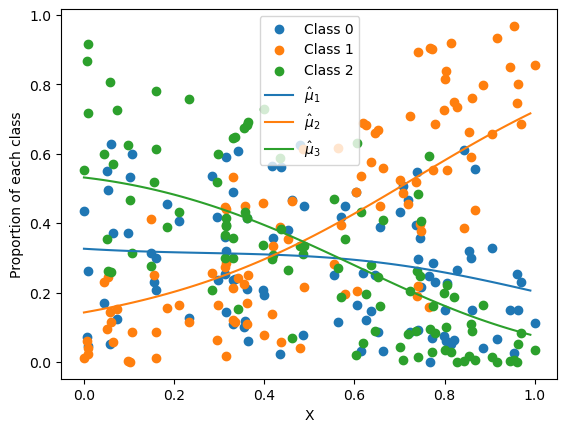

In [432]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
#plt.plot(X_for_plot[:,1], mu_for_plot)
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot, label=['$\hat\mu_1$','$\hat\mu_2$','$\hat\mu_3$'])
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [433]:
print('R2 score mu :',r2_score(mu,mu_sol_3))
print('RMSE mu :',mean_squared_error(mu,mu_sol_3,squared=False))

R2 score mu : 0.7924821070606233
RMSE mu : 0.05108149218175125


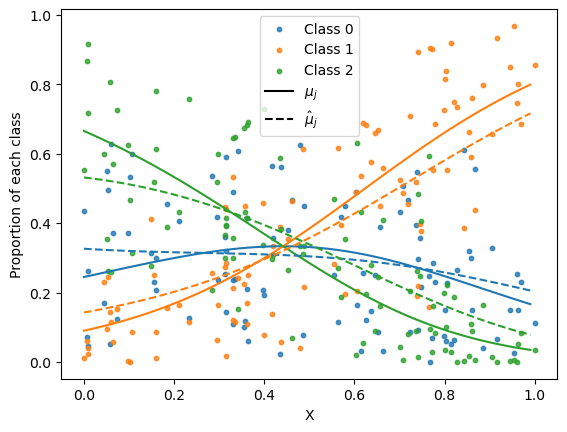

In [434]:
class0=plt.scatter(X[:,1],Y[:,0], alpha=.8, s=10)
class1=plt.scatter(X[:,1],Y[:,1], alpha=.8, s=10)
class2=plt.scatter(X[:,1],Y[:,2],alpha=.8, s=10)
plt.plot(X_for_plot[:,1], mu_for_plot[:,0])
plt.plot(X_for_plot[:,1], mu_for_plot[:,1])
plt.plot(X_for_plot[:,1], mu_for_plot[:,2])
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], '--', color='tab:blue')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], '--', color='tab:orange')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], '--', color='tab:green')

line = plt.Line2D([],[],linestyle='-', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
plt.legend([class0,class1,class2,line,dashed_line],['Class 0','Class 1','Class 2','$\mu_j$','$\hat\mu_j$'])
plt.legend
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [435]:
print('R2 score between Y and mu :',r2_score(Y,mu_sol_3))
print('RMSE between Y and mu :',mean_squared_error(Y,mu_sol_3,squared=False))

R2 score between Y and mu : 0.40865372113898624
RMSE between Y and mu : 0.1680736125929223


### Solution with spatial

In [436]:
beta0 = np.zeros((n_features+2,n_classes))
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0, rho0])

In [437]:
min_bounds_3 = -np.inf*np.ones(len(params0)) 
max_bounds_3 = np.inf*np.ones(len(params0))
min_bounds_3[-1] = -1
max_bounds_3[-1] = 1
bounds_3 = Bounds(min_bounds_3, max_bounds_3)

In [447]:
neighbors = NearestNeighbors(n_neighbors=10).fit(X[:,1:])
W = neighbors.kneighbors_graph(X[:,1:]).toarray()
# replace the 1 on the diagonal by 0
np.fill_diagonal(W,0)
# scaling the matrix, so that the sum of each row is 1
W = W/W.sum(axis=1)[:,None]

In [448]:
%%time
solution_3 = minimize(f_spatial, params0, args=(X, Y, Z, W), bounds=bounds_3)

Wall time: 2.77 s


In [449]:
solution_3.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [450]:
beta_sol_3 = solution_3.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_sol_3 = solution_3.x[-1]
mu_sol_3 = dirichlet_regression.compute_mu_spatial(X, beta_sol_3, rho_sol_3, W)
gamma_var_sol_3 = solution_3.x[(n_features+2)*n_classes:-1]
phi_sol_3 = np.exp(np.matmul(Z,gamma_var_sol_3))

In [451]:
print('PREDICTED')
print('beta',beta_sol_3)
print('gamma',gamma_var_sol_3)
print('rho',rho_sol_3)
print('----- \nREAL')
print('beta',beta)
print('gamma',gamma_var)

PREDICTED
beta [[ 0.         -0.47688497  0.24266798]
 [ 0.          1.1153344   0.11178854]
 [ 0.          0.04594901 -0.93828393]]
gamma [1.73434077]
rho 0.5815100371064341
----- 
REAL
beta [[ 0.  -1.   1. ]
 [ 0.   2.  -2. ]
 [ 0.   0.6 -0.6]]
gamma [1.75]


In [452]:
mu_sol_3_for_plot = dirichlet_regression.compute_mu_spatial(X_for_plot, beta_sol_3, rho_sol_3, W_for_plot)

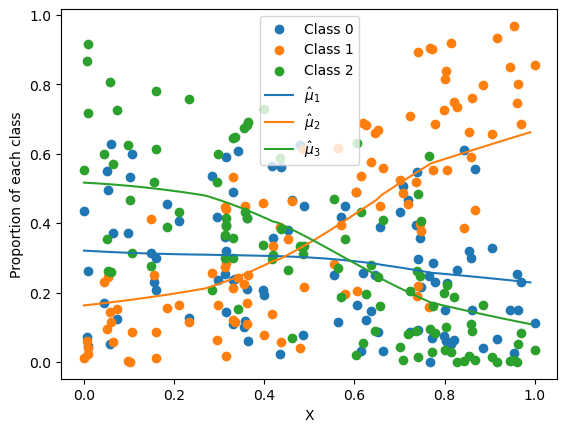

In [453]:
plt.scatter(X[:,1],Y[:,0],label='Class 0')
plt.scatter(X[:,1],Y[:,1],label='Class 1')
plt.scatter(X[:,1],Y[:,2],label='Class 2')
#plt.plot(X_for_plot[:,1], mu_for_plot)
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot, label=['$\hat\mu_1$','$\hat\mu_2$','$\hat\mu_3$'])
plt.legend()
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [454]:
print('R2 score mu :',r2_score(mu,mu_sol_3))
print('RMSE mu :',mean_squared_error(mu,mu_sol_3,squared=False))

R2 score mu : 0.8145375142315396
RMSE mu : 0.030592253733585022


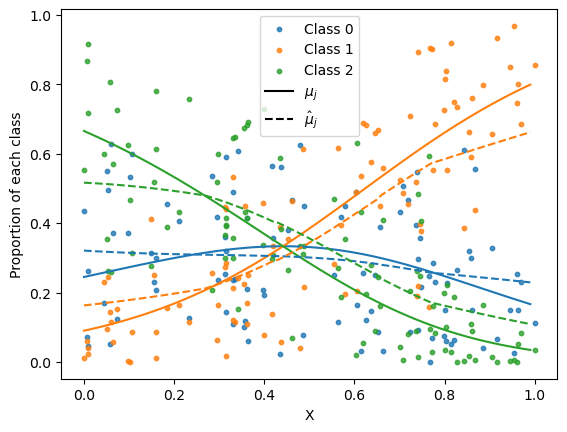

In [455]:
class0=plt.scatter(X[:,1],Y[:,0], alpha=.8, s=10)
class1=plt.scatter(X[:,1],Y[:,1], alpha=.8, s=10)
class2=plt.scatter(X[:,1],Y[:,2],alpha=.8, s=10)
plt.plot(X_for_plot[:,1], mu_for_plot[:,0])
plt.plot(X_for_plot[:,1], mu_for_plot[:,1])
plt.plot(X_for_plot[:,1], mu_for_plot[:,2])
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,0], '--', color='tab:blue')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,1], '--', color='tab:orange')
plt.plot(X_for_plot[:,1], mu_sol_3_for_plot[:,2], '--', color='tab:green')

line = plt.Line2D([],[],linestyle='-', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
plt.legend([class0,class1,class2,line,dashed_line],['Class 0','Class 1','Class 2','$\mu_j$','$\hat\mu_j$'])
plt.legend
plt.xlabel('X')
plt.ylabel('Proportion of each class')
plt.show()

In [456]:
print('R2 score between Y and mu :',r2_score(Y,mu_sol_3))
print('RMSE between Y and mu :',mean_squared_error(Y,mu_sol_3,squared=False))

R2 score between Y and mu : 0.42598989456411207
RMSE between Y and mu : 0.16468791720165546


# Computation time?